In [18]:
from pathlib import Path
import numpy as np, joblib
import glob as glob
import re
from tempfile import mkdtemp

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from scipy.stats import randint, loguniform
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [19]:
dataset_root = r"C:\Users\ankit\Desktop\Data Mining\Lab assignment\op_spam_v1.4\negative_polarity"
folders = ["truthful_from_Web", "deceptive_from_MTurk"]
labels = ["Truthful", "Deceptive"]


In [20]:
def load_data(dataset_root, folders):
    review, label, fold = [], [], []
    root = Path(dataset_root)
    for label_idx, folder in enumerate(folders):
        for fold_dir in sorted((root/folder).iterdir(), key=lambda p:p.name):
            fold_name = fold_dir.name
            for file in fold_dir.glob("*.txt"):
                review.append(file.read_text())
                label.append(label_idx)
                fold.append(fold_name)
    return np.array(review), np.array(label), np.array(fold) 

In [21]:
x, y, fold_id = load_data(dataset_root, folders)
test_folder = "fold5"
train_folder = fold_id != test_folder
x_train, y_train, fold_train = x[train_folder], y[train_folder], np.array([int(f.replace("fold", "")) for f in fold_id[train_folder]])
x_test, y_test = x[~train_folder], y[~train_folder]

Unigram

In [22]:
uni_pipe = Pipeline([
    ("vectorizer", TfidfVectorizer(stop_words="english", lowercase=True, ngram_range=(1,1))),
    ("classifier", DecisionTreeClassifier(class_weight="balanced", random_state=42))
])
uni_pipe.memory = mkdtemp()

In [23]:
uni_grid = {
    "classifier__criterion": ["gini", "entropy", "log_loss"],
    "classifier__max_depth": [None, 5, 10, 20],
    "classifier__min_samples_split": randint(10,51),
    "classifier__min_samples_leaf": randint(2,11),
    "classifier__ccp_alpha":[0.0, 1e-4, 3e-4, 1e-3, 3e-3],

    "vectorizer__min_df": [1, 2, 5],
    "vectorizer__max_features": [None, 10000, 20000],
    "vectorizer__max_df": [1.0, 0.95, 0.9]
}

In [24]:
cv = GroupKFold(n_splits=4)

In [25]:
uni_model = RandomizedSearchCV(
    uni_pipe, uni_grid, cv = cv, n_iter =30, scoring = "f1", n_jobs=1, random_state=42, verbose=1
)
uni_model.fit(x_train, y_train, groups=fold_train)

Fitting 4 folds for each of 30 candidates, totalling 120 fits


RandomizedSearchCV(cv=GroupKFold(n_splits=4),
                   estimator=Pipeline(memory='C:\\Users\\ankit\\AppData\\Local\\Temp\\tmp6u4rsvii',
                                      steps=[('vectorizer',
                                              TfidfVectorizer(stop_words='english')),
                                             ('classifier',
                                              DecisionTreeClassifier(class_weight='balanced',
                                                                     random_state=42))]),
                   n_iter=30, n_jobs=1,
                   param_distributions={'classifier__ccp_alpha': [0.0, 0.0001,
                                                                  0.0003, 0...
                                        'classifier__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000210C7136F00>,
                                        'classifier__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000210C7135370>,
                                        'vectorizer__max_df': [1.0, 0.95, 0.9],
                                        'vectorizer__max_features': [None,
                                                                     10000,
                                                                     20000],
                                        'vectorizer__min_df': [1, 2, 5]},
                   random_state=42, scoring='f1', verbose=1)

Best params: {'classifier__ccp_alpha': 0.0001, 'classifier__criterion': 'entropy', 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 30, 'vectorizer__max_df': 1.0, 'vectorizer__max_features': 10000, 'vectorizer__min_df': 2}
Unigram accuracy: 0.68125
              precision    recall  f1-score   support

    Truthful       0.67      0.70      0.69        80
   Deceptive       0.69      0.66      0.68        80

    accuracy                           0.68       160
   macro avg       0.68      0.68      0.68       160
weighted avg       0.68      0.68      0.68       160



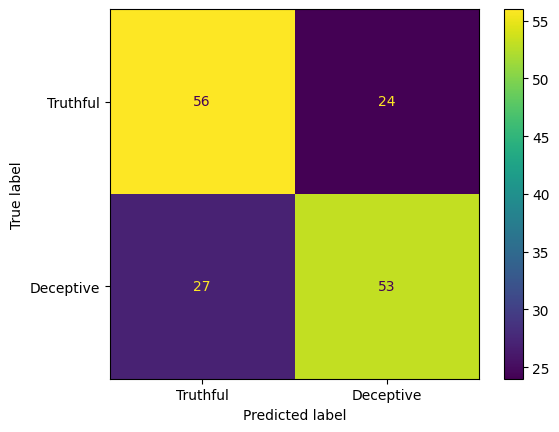

In [26]:
y_pred_uni = uni_model.best_estimator_.predict(x_test)

print("Best params:", uni_model.best_params_)
print("Unigram accuracy:", accuracy_score(y_test, y_pred_uni))
print(classification_report(y_test, y_pred_uni, target_names=labels))
uni_cm = confusion_matrix(y_test, y_pred_uni)

ConfusionMatrixDisplay(uni_cm, display_labels=labels).plot(cmap='viridis', colorbar=True)

Unigram and Bigram

In [27]:
#Bigram
bi_pipe = Pipeline([
    ("vectorizer", CountVectorizer(stop_words="english", lowercase=True, ngram_range=(1,2))),
    ("classifier", DecisionTreeClassifier(class_weight="balanced", random_state=42))
])
bi_pipe.memory = mkdtemp()

In [28]:
bi_grid = {
    "classifier__criterion": ["gini", "entropy", "log_loss"],
    "classifier__max_depth": [None, 5, 10, 20],
    "classifier__min_samples_split": randint(10,51),
    "classifier__min_samples_leaf": randint(2,11),
    "classifier__ccp_alpha":[0.0, 1e-4, 3e-4, 1e-3, 3e-3],

    "vectorizer__min_df": [2, 5],
    "vectorizer__max_features": [None, 10000, 20000],
    "vectorizer__max_df": [1.0, 0.95]
}

In [29]:
bi_model = RandomizedSearchCV(
    bi_pipe, bi_grid, cv = cv, n_iter =30, scoring = "f1", n_jobs=1, random_state=42, verbose=1
)
bi_model.fit(x_train, y_train, groups=fold_train)

Fitting 4 folds for each of 30 candidates, totalling 120 fits


RandomizedSearchCV(cv=GroupKFold(n_splits=4),
                   estimator=Pipeline(memory='C:\\Users\\ankit\\AppData\\Local\\Temp\\tmpkag1pkpv',
                                      steps=[('vectorizer',
                                              CountVectorizer(ngram_range=(1,
                                                                           2),
                                                              stop_words='english')),
                                             ('classifier',
                                              DecisionTreeClassifier(class_weight='balanced',
                                                                     random_state=42))]),
                   n_iter=30, n_jobs=1,
                   param_distributions={'classifier__ccp_alpha': [0...
                                        'classifier__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000210CB53ADE0>,
                                        'classifier__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000210CB28C950>,
                                        'vectorizer__max_df': [1.0, 0.95],
                                        'vectorizer__max_features': [None,
                                                                     10000,
                                                                     20000],
                                        'vectorizer__min_df': [2, 5]},
                   random_state=42, scoring='f1', verbose=1)

Best params: {'classifier__ccp_alpha': 0.001, 'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 9, 'classifier__min_samples_split': 30, 'vectorizer__max_df': 0.95, 'vectorizer__max_features': None, 'vectorizer__min_df': 5}
Bigram accuracy: 0.675
              precision    recall  f1-score   support

    Truthful       0.66      0.74      0.69        80
   Deceptive       0.70      0.61      0.65        80

    accuracy                           0.68       160
   macro avg       0.68      0.68      0.67       160
weighted avg       0.68      0.68      0.67       160



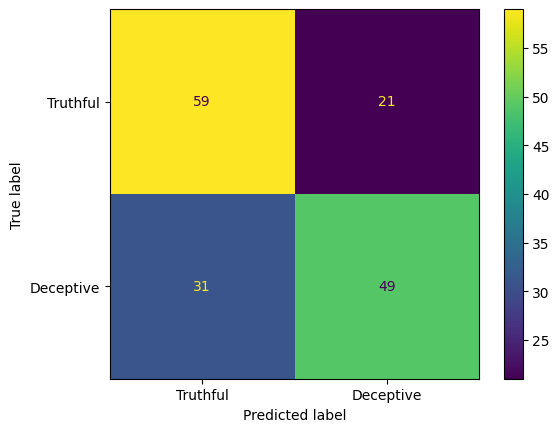

In [30]:
y_pred_bi = bi_model.best_estimator_.predict(x_test)

print("Best params:", bi_model.best_params_)
print("Bigram accuracy:", accuracy_score(y_test, y_pred_bi))
print(classification_report(y_test, y_pred_bi, target_names=labels))
bi_cm = confusion_matrix(y_test, y_pred_bi)

ConfusionMatrixDisplay(bi_cm, display_labels=labels).plot(cmap='viridis', colorbar=True)